In [ ]:
import io
import os
import math
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import seed
seed(1)
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import shutil
import pickle as pk

import tensorflow
tensorflow.random.set_seed(1)
from tensorflow.python.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.python.keras.models import Sequential

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn import metrics
from sklearn import datasets, ensemble


from keras import models
from keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

In [ ]:
from google.colab import drive
drive.mount('./mount')

Mounted at ./mount


In [ ]:
folder_path = '/content/mount/MyDrive/Colab Notebooks/nitrate/'
readDataset_name = 'nitrate_k.csv'
dataset_path = folder_path + readDataset_name
df = pd.read_csv(dataset_path, header=0)
print(df)

         size  surface   zvi   ph oxygen  temp  nitrate         k
0       90.00    49.46  2.88  6.7      A    30    100.0  0.033300
1    85000.00     0.06  2.00  2.0     AN    20     25.0  0.017200
2       30.00    62.20  0.05  6.0     AN    25     20.0  0.024400
3       16.70    79.06  1.25  7.0     AN    30    100.0  0.068000
4       75.00     4.20  0.50  7.0     AA    25     62.0  0.004417
..        ...      ...   ...  ...    ...   ...      ...       ...
283     50.00    39.36  2.00  7.0      A    20     70.0  0.015000
284     50.00    39.36  2.00  3.0      A    20     50.0  0.091000
285     11.65    17.96  4.00  6.0     AA    20     20.0  0.021600
286     50.00    39.36  5.00  5.0      A    20     95.0  0.029000
287     11.65    17.96  4.00  9.0     AA    20     20.0  0.004900

[288 rows x 8 columns]


Convert

In [ ]:
print(df['oxygen'].unique())

['A' 'AN' 'AA']


In [ ]:
zvi_df = pd.get_dummies(df, columns = ['oxygen'])

print(zvi_df)

         size  surface   zvi   ph  temp  nitrate         k  oxygen_A  \
0       90.00    49.46  2.88  6.7    30    100.0  0.033300         1   
1    85000.00     0.06  2.00  2.0    20     25.0  0.017200         0   
2       30.00    62.20  0.05  6.0    25     20.0  0.024400         0   
3       16.70    79.06  1.25  7.0    30    100.0  0.068000         0   
4       75.00     4.20  0.50  7.0    25     62.0  0.004417         0   
..        ...      ...   ...  ...   ...      ...       ...       ...   
283     50.00    39.36  2.00  7.0    20     70.0  0.015000         1   
284     50.00    39.36  2.00  3.0    20     50.0  0.091000         1   
285     11.65    17.96  4.00  6.0    20     20.0  0.021600         0   
286     50.00    39.36  5.00  5.0    20     95.0  0.029000         1   
287     11.65    17.96  4.00  9.0    20     20.0  0.004900         0   

     oxygen_AA  oxygen_AN  
0            0          0  
1            0          1  
2            0          1  
3            0         

In [ ]:
saveDataset_name = 'nitrate-OHE.csv'
saveDataset_path = folder_path + saveDataset_name

if os.path.exists(saveDataset_path):
  os.remove(saveDataset_path)
  pass

zvi_df.to_csv(saveDataset_path)
print(zvi_df.loc[0,:])

size          90.0000
surface       49.4600
zvi            2.8800
ph             6.7000
temp          30.0000
nitrate      100.0000
k              0.0333
oxygen_A       1.0000
oxygen_AA      0.0000
oxygen_AN      0.0000
Name: 0, dtype: float64


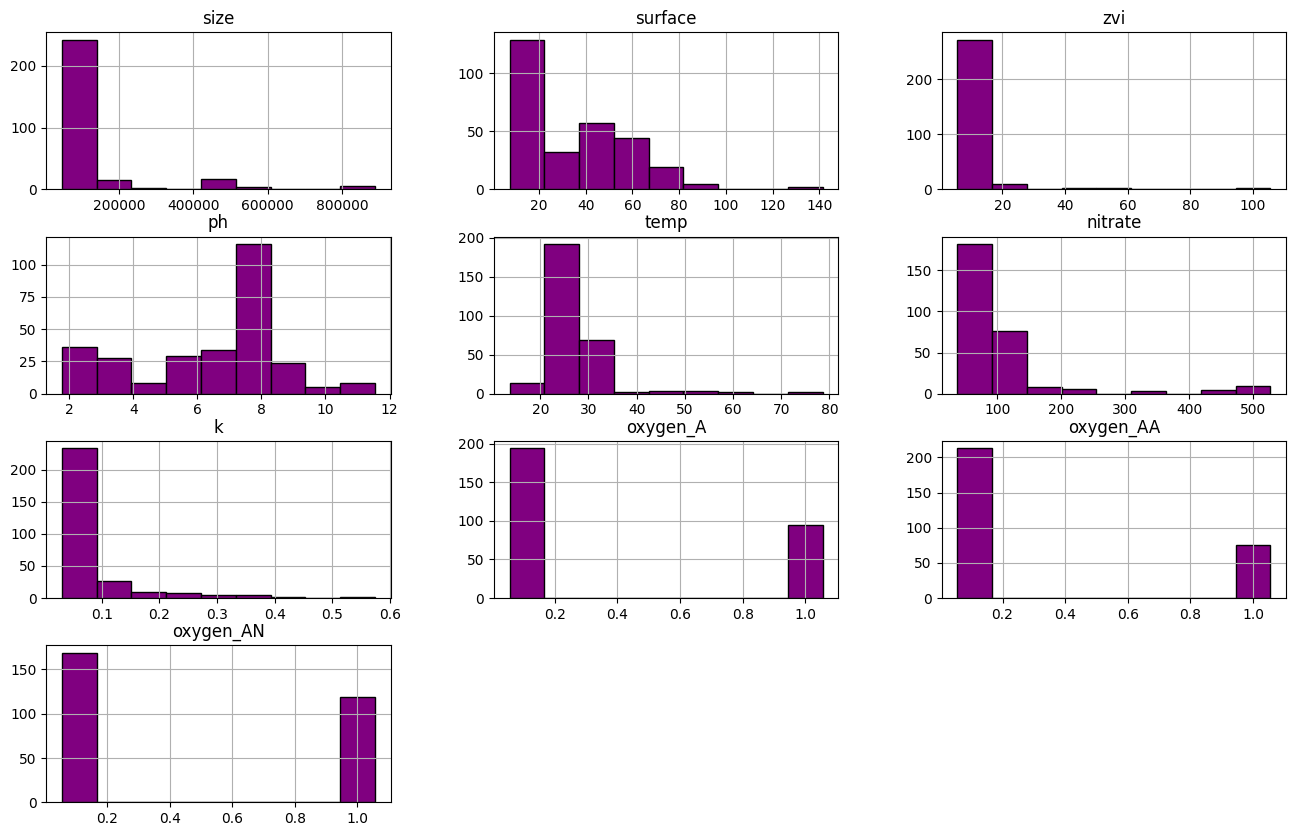

In [ ]:
zvi_df.hist(bins=9, figsize=(16,10),align='right', color='purple', edgecolor='black')
plt.show()

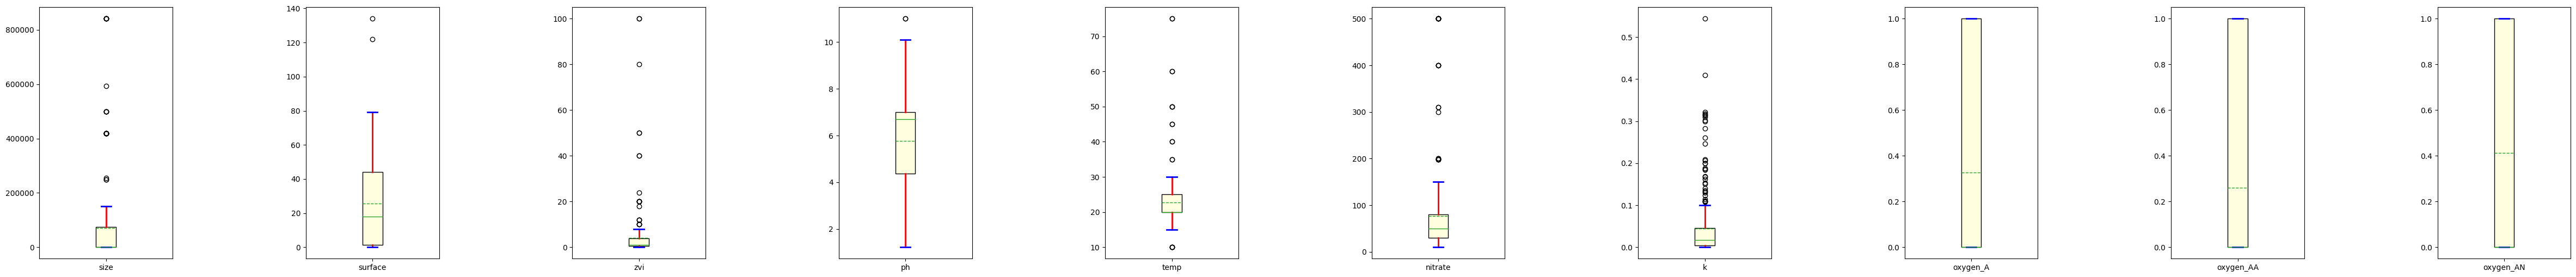

In [ ]:
zvi_df.plot(kind='box', subplots=True, sharey=False, figsize=(60, 6), patch_artist=True, showmeans = True, meanline = True, whiskerprops = dict(color = "red", linewidth = 2),
        capprops = dict(color = "blue", linewidth = 2), boxprops=dict(facecolor='lightyellow'))

plt.subplots_adjust(wspace=1)
plt.show()

Split the data - variable and target

In [ ]:
target=['k']
features=['size', 'surface', 'zvi', 'ph', 'temp', 'oxygen_A', 'oxygen_AA', 'oxygen_AN', 'nitrate']

x=zvi_df[features].values
y=zvi_df[target].values

Split the training and test data

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

In [ ]:
print(x_train.shape)
print(x_test.shape)

(259, 9)
(29, 9)


#GBDT

Parameter

In [ ]:
params = {
    "n_estimators": 1000,
    "max_depth": 8,
    "min_samples_split": 7,
    "learning_rate": 0.01,
    "loss": "squared_error",
}

In [ ]:
%%time

reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(x_train, y_train)

mse = mean_squared_error(y_test, reg.predict(x_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The mean squared error (MSE) on test set: 0.0007
CPU times: user 1.13 s, sys: 6.73 ms, total: 1.13 s
Wall time: 1.15 s


In [ ]:
%%time

score = reg.score(x_train, y_train)
scores = cross_val_score(reg, x_train, y_train, cv=5)
kfold = KFold(n_splits=5, shuffle=True)
kf_cv_scores = cross_val_score(reg, x_train, y_train, cv=kfold)

print("Training score: ", score)
print("Mean cross-validation score: %.2f" % scores.mean())
print("K-Fold CV average score: %.2f" % kf_cv_scores.mean())

y_pred = reg.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
print("RMSE: %.2f" % (mse**(1/2.0)))

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 

Training score:  0.9882321770247193
Mean cross-validation score: 0.19
K-Fold CV average score: 0.20
RMSE: 0.03
CPU times: user 11.4 s, sys: 23.8 ms, total: 11.4 s
Wall time: 11.6 s


In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred, squared=False))
print('Mean Absolute Percentage Error:', metrics.mean_absolute_percentage_error(y_test, y_pred))
print('Coefficient of determination:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error: 0.016181166501162976
Mean Squared Error: 0.0007119694901680342
Root Mean Squared Error: 0.026682756419980944
Mean Absolute Percentage Error: 3.2364238154511598
Coefficient of determination: 0.8075655076084758


In [ ]:
def pseudo_huber_loss(y_pred, y_test):
    d = (y_test-y_pred)
    delta = 1
    scale = 1 + (d / delta) ** 2
    scale_sqrt = np.sqrt(scale)
    grad = d / scale_sqrt
    hess = (1 / scale) / scale_sqrt
    return grad, hess

Pot

In [ ]:
df_y_test = pd.DataFrame(y_test)
df_y_pred = pd.DataFrame(y_pred)

df_y_test.reset_index(drop=True, inplace=True)
df_y_pred.reset_index(drop=True, inplace=True)

df_results = pd.concat([df_y_test, df_y_pred], axis=1)
df_results.columns = ['Actual', 'Predicted']

df_results

,Actual,Predicted
0,0.301500,0.286728
1,0.009400,0.015390
2,0.029000,0.034450
3,0.000200,0.003168
4,0.001083,0.005113
5,0.010000,0.007119
6,0.054000,0.050724
7,0.006967,0.003728
8,0.004000,-0.008817
9,0.002167,0.005983


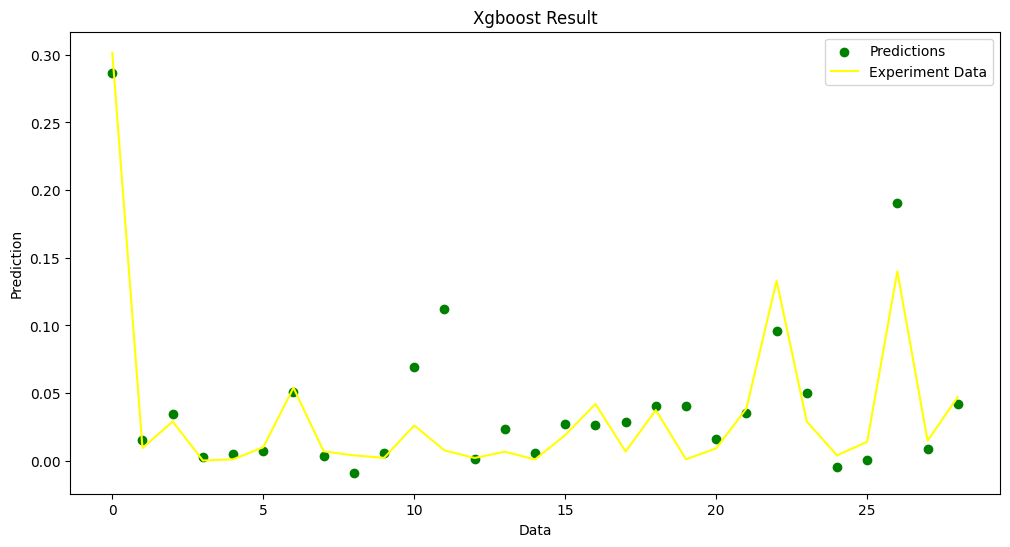

In [ ]:
plt.figure(figsize=(12,6))
plt.scatter(range(len(y_pred)), y_pred,color = 'green', label= 'Predictions')
plt.plot(range(len(y_test)), y_test,color = 'yellow', label= 'Experiment Data')
plt.title('Xgboost Result')
plt.ylabel('Prediction')
plt.xlabel('Data')
plt.legend()
plt.show()

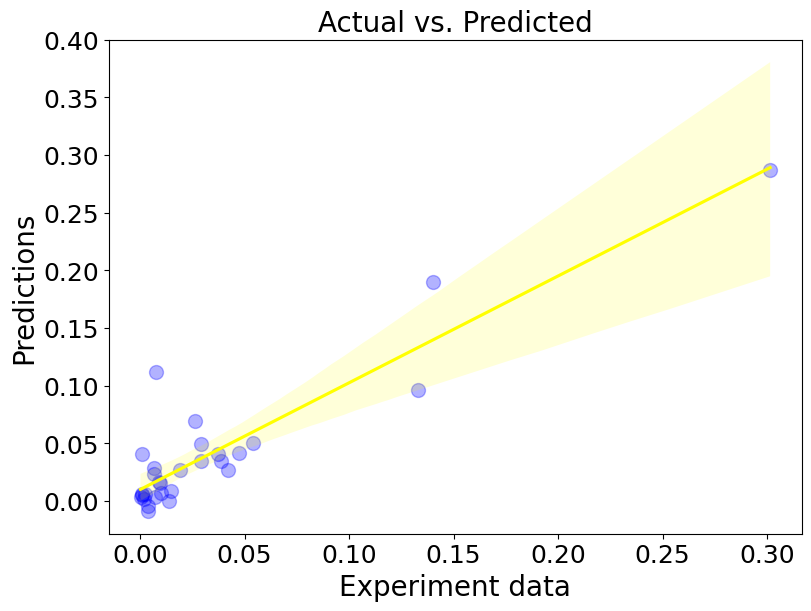

In [ ]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True)
sns.regplot(x=df_y_test, y=df_y_pred, ax=ax, color='yellow', scatter_kws={"fc":"b", "ec":"b", "s":100, "alpha":0.3})
ax.set_xlabel("Experiment data", fontsize = 20)
ax.set_ylabel("Predictions", fontsize = 20)
plt.title('Actual vs. Predicted', fontsize = 20)
plt.xticks(size=18)
plt.yticks(size=18)

fig.savefig("103_snsreglmplot_01.png")